In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# setting current directory
%cd /content/drive/My\ Drive

/content/drive/My Drive


### Importing necessary libraries

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [5]:
# importing libraries
from fastai.vision import *
from fastai.metrics import *
from fastai.callbacks import *

### Setting path and batch-size

In [6]:
# setting batch size
bs = 64

In [7]:
# setting path of dataset
path =Path('Vehicle_dataset')
path

PosixPath('Vehicle_dataset')

In [8]:
path.ls()

[PosixPath('Vehicle_dataset/test_images_actual_label.csv'),
 PosixPath('Vehicle_dataset/test_images'),
 PosixPath('Vehicle_dataset/train_images'),
 PosixPath('Vehicle_dataset/models'),
 PosixPath('Vehicle_dataset/result_resnet34.csv'),
 PosixPath('Vehicle_dataset/result_resnet34_a.csv'),
 PosixPath('Vehicle_dataset/Copy of vehicle.ipynb'),
 PosixPath('Vehicle_dataset/vehicle.ipynb')]

In [9]:
(path/'train_images').ls()

[PosixPath('Vehicle_dataset/train_images/non_emergency'),
 PosixPath('Vehicle_dataset/train_images/emergency'),
 PosixPath('Vehicle_dataset/train_images/models')]

In [10]:
path_img = path/'train_images'

### Data Augmentation and creating image databunch

In [11]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [12]:
# creating image databunch and setting validation percentage to 20%
data = ImageDataBunch.from_folder(path,train='train_images',test='test_images',seed=1,valid_pct=0.2, ds_tfms=tfms, size=224,bs=bs).normalize(imagenet_stats)

In [13]:
data

ImageDataBunch;

Train: LabelList (1317 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
non_emergency,non_emergency,non_emergency,non_emergency,non_emergency
Path: Vehicle_dataset;

Valid: LabelList (329 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
non_emergency,emergency,emergency,non_emergency,emergency
Path: Vehicle_dataset;

Test: LabelList (716 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: Vehicle_dataset

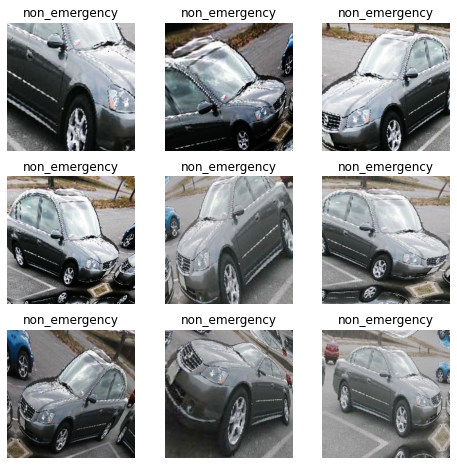

In [14]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

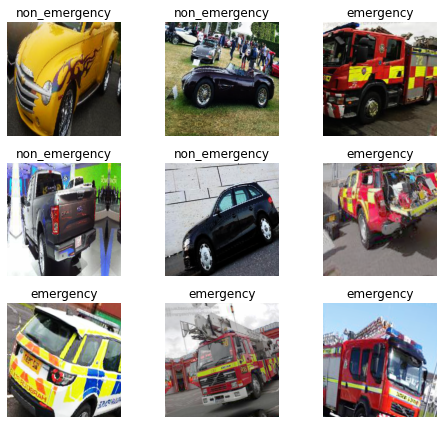

In [15]:
data.show_batch(rows=3, figsize=(7,6))

In [16]:
# printing no of classes in our dataset
print(data.classes)
len(data.classes),data.c

['emergency', 'non_emergency']


(2, 2)

### Training: resnet34

In [17]:
# training model by using resnet34
learn_resnet34 = cnn_learner(data, models.resnet34, metrics=[error_rate,accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [18]:
learn_resnet34.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

#### finding optimum learning rate and training model with 10 epochs

In [19]:
# finding optimum learning rate by lr finder
learn_resnet34.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


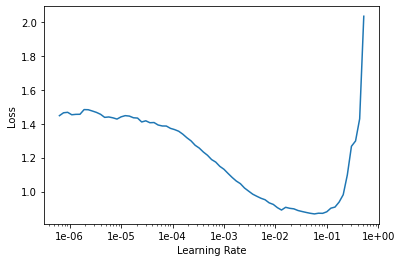

In [20]:
learn_resnet34.recorder.plot()

In [21]:
# train for 10 epochs (10 cycles through all our data and save best model in terms of accuracy using callbacks
learn_resnet34.fit_one_cycle(10,max_lr=1e-02,callbacks=[SaveModelCallback(learn_resnet34,every="improvement",monitor='accuracy',name='best_resnet34')])

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.542486,0.441256,0.088146,0.911854,01:56
1,0.458838,0.459075,0.106383,0.893617,00:15
2,0.383052,0.262370,0.091185,0.908815,00:14
3,0.343739,0.227211,0.072948,0.927052,00:14
4,0.301331,0.187365,0.060790,0.939210,00:15
5,0.261772,0.197549,0.072948,0.927052,00:15
6,0.237955,0.184653,0.060790,0.939210,00:14
7,0.202357,0.180970,0.066869,0.933131,00:14
8,0.181992,0.166304,0.066869,0.933131,00:14
9,0.163045,0.162099,0.066869,0.933131,00:14


Better model found at epoch 0 with accuracy value: 0.911854088306427.
Better model found at epoch 3 with accuracy value: 0.9270516633987427.
Better model found at epoch 4 with accuracy value: 0.9392096996307373.


#### Interpretations

In [22]:
# Interpretations
interp = ClassificationInterpretation.from_learner(learn_resnet34)

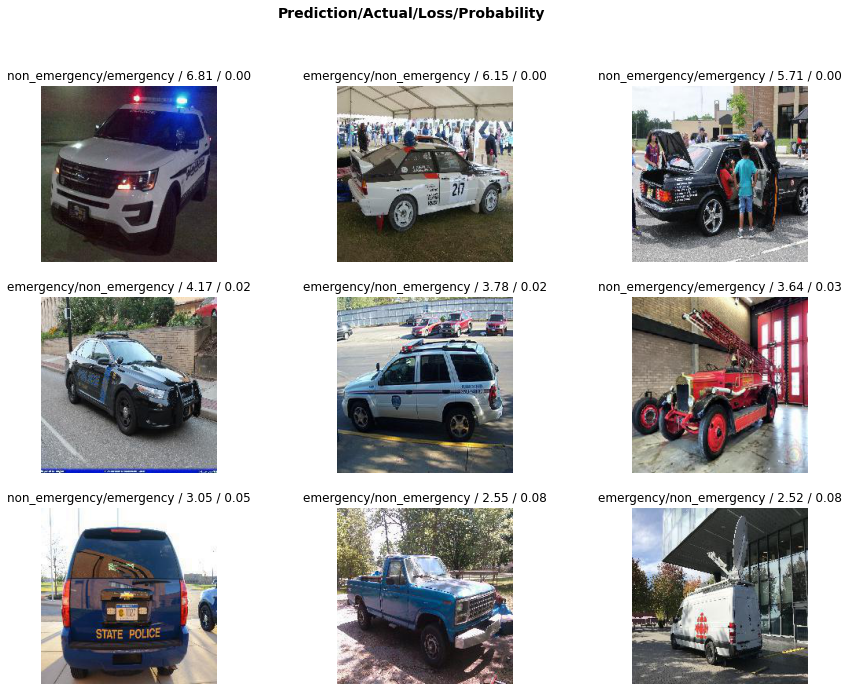

In [23]:
# plotting images that are contributing to maximum loss
interp.plot_top_losses(9, figsize=(15,11))

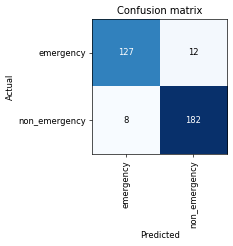

In [24]:
# plotting confusion matrix
interp.plot_confusion_matrix(dpi=60)

In [25]:
# interpreting most confused images
interp.most_confused(min_val=2)

[('emergency', 'non_emergency', 12), ('non_emergency', 'emergency', 8)]

#### loading best model and unfreezing all layers of model for fine-tuning and saving best model using callback

In [26]:
learn_resnet34.load('best_resnet34')

Learner(data=ImageDataBunch;

Train: LabelList (1317 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
non_emergency,non_emergency,non_emergency,non_emergency,non_emergency
Path: Vehicle_dataset;

Valid: LabelList (329 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
non_emergency,emergency,emergency,non_emergency,emergency
Path: Vehicle_dataset;

Test: LabelList (716 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: Vehicle_dataset, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, paddin

In [27]:
# unfreezing model to perform fine tuning
learn_resnet34.unfreeze()

In [28]:
# training whole model after unfreezing
learn_resnet34.fit_one_cycle(1, max_lr=slice(1e-4,1e-2))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.295031,0.393642,0.115502,0.884498,00:15


In [ ]:
# by this accuracy drops as whole resnet model layers are trained from starting with same learning rate

In [29]:
# loading previously saved model
learn_resnet34.load('best_resnet34')

Learner(data=ImageDataBunch;

Train: LabelList (1317 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
non_emergency,non_emergency,non_emergency,non_emergency,non_emergency
Path: Vehicle_dataset;

Valid: LabelList (329 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
non_emergency,emergency,emergency,non_emergency,emergency
Path: Vehicle_dataset;

Test: LabelList (716 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: Vehicle_dataset, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, paddin

In [30]:
# again unfreezing and training model with different learning rates i.e. initial layers are trained with small learning rate because we don't want to change them more
learn_resnet34.unfreeze()
learn_resnet34.fit_one_cycle(10, max_lr=slice(1e-4,1e-2),callbacks=[SaveModelCallback(learn_resnet34,every="improvement",monitor='accuracy',name='best_finetuned_resnet34')])

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.199804,0.337734,0.088146,0.911854,00:15
1,0.191105,0.262052,0.063830,0.936170,00:16
2,0.261816,0.306674,0.136778,0.863222,00:16
3,0.264551,0.233980,0.075988,0.924012,00:15
4,0.249539,0.289218,0.082067,0.917933,00:15
5,0.228654,0.424068,0.145897,0.854103,00:15
6,0.201873,0.386555,0.127660,0.872340,00:15
7,0.167629,0.357567,0.085106,0.914894,00:15
8,0.152402,0.292538,0.085106,0.914894,00:15
9,0.123916,0.278821,0.079027,0.920973,00:16


Better model found at epoch 0 with accuracy value: 0.911854088306427.
Better model found at epoch 1 with accuracy value: 0.936170220375061.


### Training model with Resnet50

In [31]:
learn_resnet50 = cnn_learner(data, models.resnet50, metrics=[error_rate,accuracy])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [32]:
learn_resnet50.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


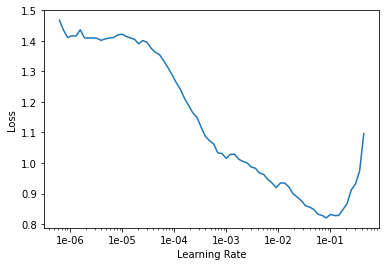

In [33]:
learn_resnet50.recorder.plot()

In [34]:
learn_resnet50.fit_one_cycle(10, max_lr=slice(1e-2),callbacks=[SaveModelCallback(learn_resnet50,every="improvement",monitor='accuracy',name='best_resnet50')])

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.579989,0.382823,0.072948,0.927052,00:17
1,0.464402,0.280564,0.088146,0.911854,00:17
2,0.389511,0.155396,0.051672,0.948328,00:16
3,0.319174,0.139420,0.057751,0.942249,00:17
4,0.266256,0.154057,0.060790,0.939210,00:16
5,0.233717,0.137560,0.057751,0.942249,00:16
6,0.214649,0.134541,0.039514,0.960486,00:17
7,0.198953,0.109432,0.042553,0.957447,00:17
8,0.165802,0.101632,0.039514,0.960486,00:17
9,0.147440,0.100242,0.039514,0.960486,00:16


Better model found at epoch 0 with accuracy value: 0.9270516633987427.
Better model found at epoch 2 with accuracy value: 0.9483282566070557.
Better model found at epoch 6 with accuracy value: 0.9604862928390503.


In [35]:
# fine tuning model
learn_resnet50.unfreeze()
# fine tuning model
learn_resnet50.fit_one_cycle(10, max_lr=slice(1e-4,1e-2),callbacks=[SaveModelCallback(learn_resnet50,every="improvement",monitor='accuracy',name='best_resnet50_finetuned')])

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.163094,0.264050,0.072948,0.927052,00:18
1,0.176890,0.596957,0.097264,0.902736,00:19
2,0.224842,0.792248,0.164134,0.835866,00:18
3,0.244069,0.482587,0.127660,0.872340,00:18
4,0.227818,0.368059,0.100304,0.899696,00:18
5,0.206249,0.277395,0.079027,0.920973,00:18
6,0.173924,0.295451,0.094225,0.905775,00:18
7,0.139424,0.160087,0.057751,0.942249,00:18
8,0.120306,0.170391,0.057751,0.942249,00:19
9,0.099680,0.166094,0.057751,0.942249,00:18


Better model found at epoch 0 with accuracy value: 0.9270516633987427.
Better model found at epoch 7 with accuracy value: 0.9422492384910583.


In [36]:
learn_resnet50.load('best_resnet50')

Learner(data=ImageDataBunch;

Train: LabelList (1317 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
non_emergency,non_emergency,non_emergency,non_emergency,non_emergency
Path: Vehicle_dataset;

Valid: LabelList (329 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
non_emergency,emergency,emergency,non_emergency,emergency
Path: Vehicle_dataset;

Test: LabelList (716 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: Vehicle_dataset, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, paddin

### Predictions using best model: Resnet50

In [37]:
# predicting on single image by renet34 model as it is giving better accuracy
img=data.test_ds[0][0]
p=learn_resnet50.predict(img)
print(int(p[0]))
print(str(p[0]))

1
non_emergency


In [38]:
# predicting on all test images
from tqdm import tqdm
pred=[]
images=[]
pred_s=[]
for i in tqdm(range(len(data.test_ds))):
  image=str(data.test_ds.items[i]).split('/')[-1]
  images.append(image)
  p=learn_resnet50.predict(data.test_ds[i][0])
  pred.append(int(p[0]))
  pred_s.append(str(p[0]))

100%|██████████| 716/716 [06:54<00:00,  1.73it/s]


In [39]:
# saving test image name, predicted value and class name in dataframe
df=pd.DataFrame(list(zip(images,pred,pred_s)),columns=['image_name','pred_value','pred_class'])

In [40]:
df

,image_name,pred_value,pred_class
0,1037.jpg,1,non_emergency
1,1025.jpg,1,non_emergency
2,105.jpg,0,emergency
3,1004.jpg,1,non_emergency
4,1027.jpg,1,non_emergency
...,...,...,...
711,990.jpg,0,emergency
712,96.jpg,0,emergency
713,923.jpg,0,emergency
714,963.jpg,0,emergency


In [41]:
# loading actual classes of test images
df_a=pd.read_csv('/content/drive/My Drive/Vehicle_dataset/test_images_actual_label.csv')

In [43]:
df_a.head()

,image_names,emergency_or_not
0,100.jpg,1
1,105.jpg,1
2,109.jpg,1
3,111.jpg,1
4,115.jpg,1


In [45]:
# merging actual and predicted values of test images
result_resnet50= pd.merge (df_a,df,left_on='image_names', right_on='image_name')

In [46]:
result_resnet50.head()

,image_names,emergency_or_not,image_name,pred_value,pred_class
0,100.jpg,1,100.jpg,0,emergency
1,105.jpg,1,105.jpg,0,emergency
2,109.jpg,1,109.jpg,0,emergency
3,111.jpg,1,111.jpg,0,emergency
4,115.jpg,1,115.jpg,0,emergency


In [48]:
# saving results in csv file
result_resnet50.to_csv('/content/drive/My Drive/Vehicle_dataset/result_resnet50.csv')